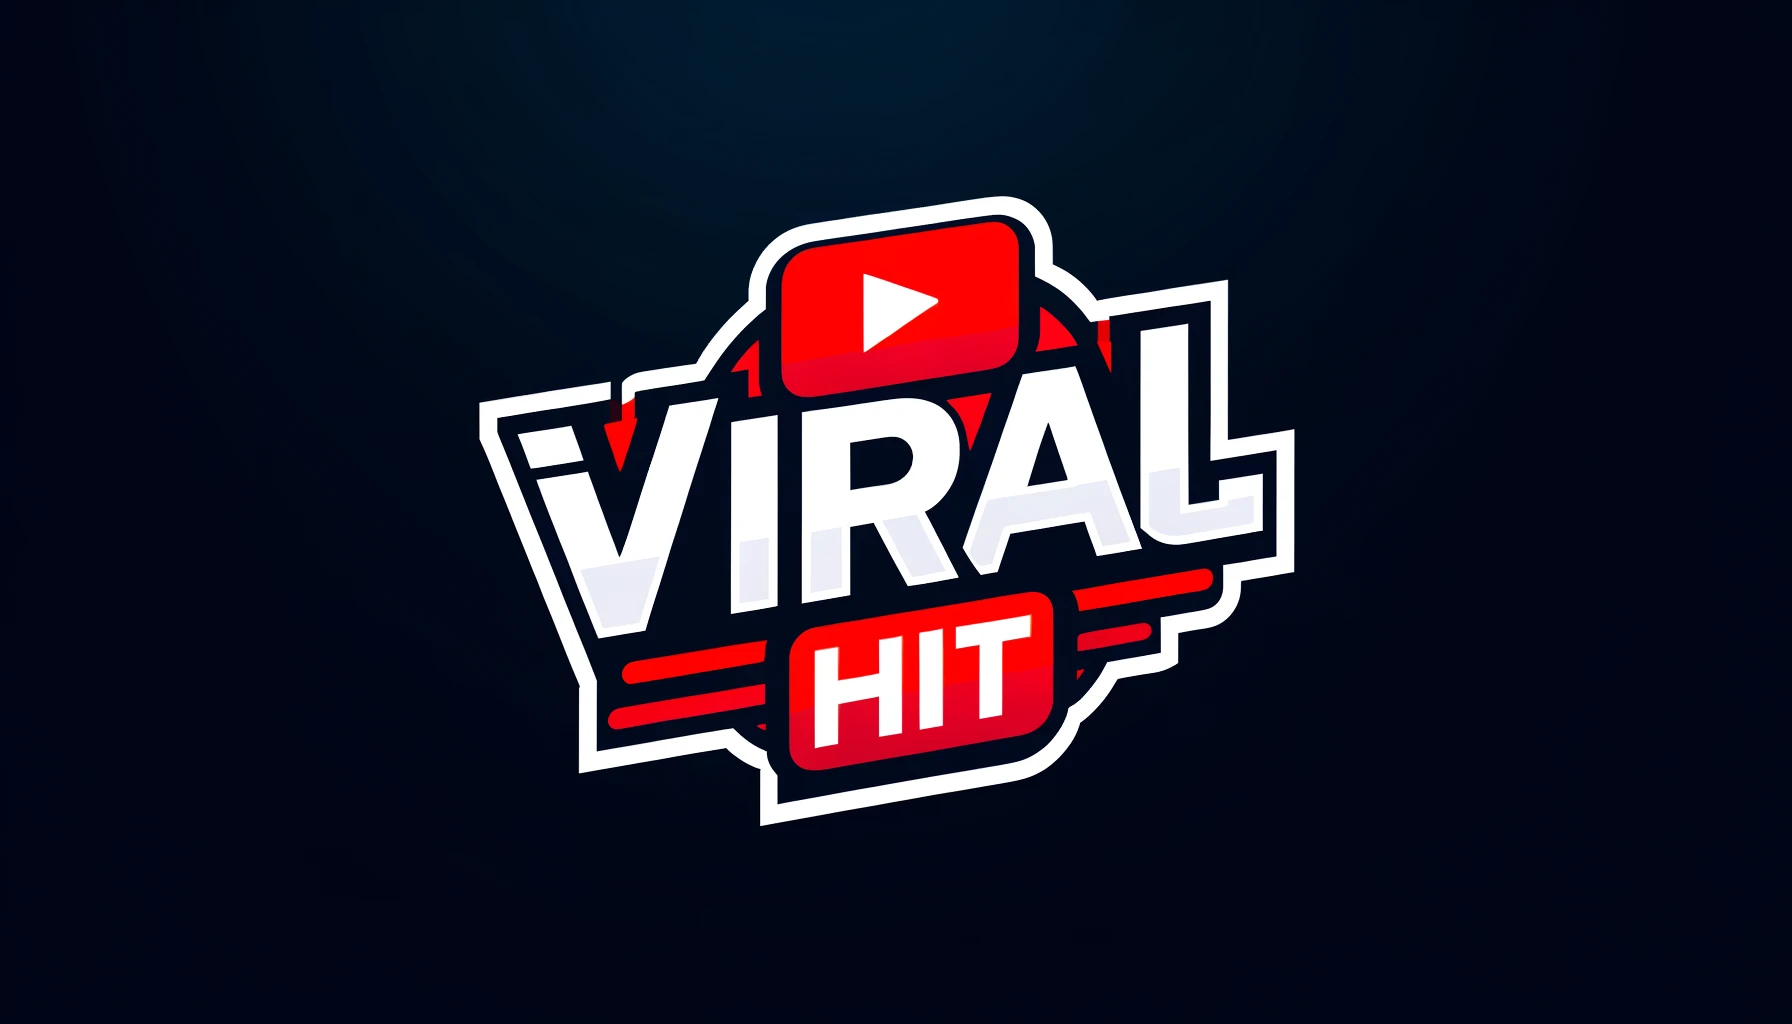

# Viral Hit
Criei clipes virais para os seus vídeos longos do Youtube! Este projeto tem como objetivo permitir que qualquer pessoa consiga encontrar os melhores momentos de seus vídeos longos para postar clipes em suas redes sociais.

Não possui um vídeo para testar? Use esse [aqui](https://www.youtube.com/live/rP-zXlQYCKY)

Este é um projeto para a a 2a edição da Imersão IA_ da Alura + Google.

# Limitações
- No momento, o Viral Hit só aceita vídeos de **8,5 horas** no modo "áudio" ou vídeos menores que **50 minutos** no modo "vídeo" (1080p). Isso é por conta do limite de tokens do Gemini. Futuramente será adicionado para escolher um intervalo de tempo menor que 50 minutos para vídeos mais longos.
- O Viral Hit não cria vídeos e legendas para os clipes. A ideia é não fugir muito do escopo de ChatBot. Por isso o resultado é uma mensagem de texto.
- O Gemini 1.5 Pro gratuito tem um limite de 32.000 Tokens por minuto. Isso é um pouco menos que 2 minutos de vídeo (600 tokens). Então um vídeo de 1 hora demoraria certa de 33 minutos para ser analisado.

# Como usar
1. Copie o arquivo viral_hit.ipynb para o seu PC
2. Vá para https://colab.research.google.com/
3. Clique em `Arquivo -> Abrir Notebook -> Upload -> Procurar` e selecione o arquivo
4. Adicione a sua chave de API ([Acesse aqui](https://aistudio.google.com/app/apikey?utm_source=website&utm_medium=referral&utm_campaign=Alura&utm_content=)) nos segredos do google colab (é a chave no menu lateral esquerdo). Clique em __Adicionar novo secret__, adicione o nome `GOOGLE_API_KEY` em em valor a sua chave. Não esqueça de ativar o secret!
5. Execute o programa. Você pode ir no menu `Ambiente de execução -> Executar tudo` ou apertar `Ctrl + F9`. Pode aparecer uma mensagem para confirmar o uso dos secrets.
6. A conversa acontecerá no final da página. Inicialmente você terá que adicionar a url do vídeo. Depois o chatbot irá pedir mais detalhes sobre o vídeo. Confirme os detalhes e aguarde.
7. O programa está no modo "áudio". Se quiser tentar o modo "vídeo", substitua **True** por **False** na última linha.

O programa possui várias etapas de processamento. Pode demorar até 2 hora para terminar no modo "vídeo". Fique de olho para que o colab não desconecte o notebook. Se você souber usar IDEs sugiro executar em sua própria máquina.

# Exemplo de Resultado
- Vídeo: https://www.youtube.com/live/rP-zXlQYCKY
- Descrição: É um vídeo de um vtuber jogando jogo de terror em primeira pessoa. Destaque reações do vtuber e momentos de sustos. O resumo deve ter no máximo 5 minutos.
- Resposta:
```
[00:01:23, 00:01:55] VTuber comenta sobre a estratégia do jogo.
[03:13, 03:19] VTuber expressa nervosismo e ansiedade antes de iniciar o jogo.
[04:41, 04:45] VTuber explica sua condição de "enjoo de movimento" e as adaptações feitas no jogo para minimizar o desconforto.
[07:58, 08:00] VTuber faz uma expressão de tristeza em antecipação aos sustos do jogo.
[15:16, 15:21] Primeiro susto com som alto e figura repentina. A VTuber grita e demonstra surpresa.
[19:42, 19:47] Segundo susto com objeto caindo e som alto. A VTuber expressa mais medo e tensão.
[25:29, 25:35] Terceiro susto com efeito sonoro inesperado. A VTuber se assusta bastante e solta um grito.
[36:52, 36:58] Quarto susto com queda repentina de objetos. VTuber grita e demonstra frustração com a armadilha.
[39:26, 39:30] VTuber se surpreende com a beleza de um cenário inesperado dentro do jogo.
```

# Instalação de bibliotecas

In [1]:
!pip install -U -q google.generativeai ffmpeg-python pytube moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.3 MB/s eta 0:00:00


# Importação e Configuração

In [2]:
import os
import re
import sys
import shutil
import json

import textwrap
from IPython.display import display
from IPython.display import Markdown

import google.generativeai as genai
from google.colab import userdata #stored it in a Colab Secret named GOOGLE_API_KEY

import cv2
import ffmpeg
from pytube import YouTube
from moviepy.editor import VideoFileClip

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

In [3]:
generation_config = {
    "candidate_count":1,
    "temperature": 0.2,
}

safety_settings = [
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
]

# Métodos

In [7]:
# Função para imprimir e substituir a última linha
def print_and_replace_last_line(message):
    sys.stdout.write(f"\r\033[K{message}")  # \r retorna ao início da linha e \033[K limpa a linha
    # sys.stdout.write(message)
    sys.stdout.flush()

# Callback para mostrar o progresso do download
def on_progress(stream, chunk, bytes_remaining):
    total_size = stream.filesize
    bytes_downloaded = total_size - bytes_remaining
    percentage_of_completion = bytes_downloaded / total_size * 100
    print_and_replace_last_line(f"Baixando: {percentage_of_completion:.2f}%")


# Valida a URL
def validate_url_youtube(url):
    youtube_regex = (
        r'(https?://)?(www\.)?'
        '(youtube|youtu|youtube-nocookie)\.(com|be)/'
        '(watch\?v=|embed/|v/|.+\?v=)?([^&=%\?]{11})'
    )
    youtube_pattern = re.compile(youtube_regex)
    if not re.match(youtube_pattern, url):
        return False
    return True


# Cria o diretório se não existir
def create_frame_output_dir(output_dir):
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)
  else:
    shutil.rmtree(output_dir)
    os.makedirs(output_dir)


VIDEO_DOWNLOAD_DIRECTORY = "./content/video"
MAX_LENGTH = 3000 # 50 minutos
MAX_LENGTH_AUDIO = 30600 # 8,5 horas
# Faz o download do vídeo do youtube
def download_video(url, only_audio):
    create_frame_output_dir(VIDEO_DOWNLOAD_DIRECTORY)
    video_path = None
    audio_path_mp4 = None

    if validate_url_youtube(url):
        try:
            yt = YouTube(url, on_progress_callback=on_progress)

            length = MAX_LENGTH_AUDIO if only_audio else MAX_LENGTH
            if yt.length <= length:

                # Seleciona o stream com a resolução para o vídeo
                video_stream = yt.streams.get_highest_resolution()
                # Define o nome do arquivo
                video_path = os.path.join(VIDEO_DOWNLOAD_DIRECTORY, f"{yt.title}.mp4")
                # Baixa o vídeo
                print("\n Vídeo:")
                video_stream.download(filename=video_path)

                # #Carregar o vídeo baixado com MoviePy (Ainda não funciona direito)
                # print("[Sistema] Só mais um pouquinho...")
                # if yt.length > MAX_LENGTH:
                #     print(f"\n[Sistema] Só serão analisados os primeiros {MAX_LENGTH/60} minutos do vídeo.")
                #     video_clip = VideoFileClip(video_path).subclip(0, MAX_LENGTH)
                #     video_clip.write_videofile(video_path, codec='libx264', verbose=True, logger=None)
                # else:
                #     video_clip = VideoFileClip(video_path)


                # Baixa o áudio
                print("\n Áudio:")
                video_clip = VideoFileClip(video_path)
                audio_clip = video_clip.audio
                audio_path_mp3 = os.path.join(VIDEO_DOWNLOAD_DIRECTORY, f"{yt.title}_audio.mp3")
                audio_clip.write_audiofile(audio_path_mp3, verbose=False)
                audio_clip.close()
                video_clip.close()

            else:
                print("\n[Sistema] Vídeo é maior que 50 minutos.")

        except Exception as e:
            print("\n[Sistema] Erro ao processar o vídeo ou áudio:", e)
    else:
        print("\n[Sistema] URL inválida. Por favor, insira um link válido do YouTube.")
    return video_path, audio_path_mp3


# https://github.com/google-gemini/cookbook/blob/main/quickstarts/Video.ipynb
FRAME_EXTRACTION_DIRECTORY = "./content/frames"
FRAME_PREFIX = "_frame"
def extract_frame_from_video(video_file_path, n_frames=1):
  create_frame_output_dir(FRAME_EXTRACTION_DIRECTORY)
  vidcap = cv2.VideoCapture(video_file_path)
  fps = vidcap.get(cv2.CAP_PROP_FPS)
  frame_duration = 1 / fps  # Tempo entre os frames (em segundos)
  output_file_prefix = os.path.basename(video_file_path).replace('.', '_')
  total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
  frame_count = 0
  count = 0
  print("")
  while vidcap.isOpened():
      success, frame = vidcap.read()
      if not success: # Fim do video
          break
      if int(count / fps) == frame_count: # Extrai n frames por segundo
          min = (frame_count) // 60
          sec = (frame_count) % 60
          time_string = f"{min:02d}-{sec:02d}"
          image_name = f"{output_file_prefix}{FRAME_PREFIX}{time_string}.jpg"
          output_filename = os.path.join(FRAME_EXTRACTION_DIRECTORY, image_name)
          cv2.imwrite(output_filename, frame)
          frame_count += 1
      count += 1
      # Calcula a porcentagem do vídeo processado
      percentage_of_completion = (count / total_frames) * 100
      print_and_replace_last_line(f"Processando: {percentage_of_completion:.2f}%")
  print("")
  vidcap.release() # Libera a captura


class File:
  def __init__(self, file_path: str, display_name: str = None):
    self.file_path = file_path
    if display_name:
      self.display_name = display_name
    self.timestamp = get_timestamp(file_path)

  def set_file_response(self, response):
    self.response = response


# Extrai a contagem de frame do nome do arquivo no formato 'output_file_prefix_frame00-00.jpg'.
def get_timestamp(filename):
    parts = filename.split(FRAME_PREFIX)
    if len(parts) != 2:
        return None  # Indica que o nome do arquivo pode estar formatado incorretamente
    return "00:" + ":".join(parts[1].split('.')[0].split("-"))


# Carrega os arquivos no Gemini
def upload_to_gemini(video_path, audio_path, only_audio=True):
    frames = []
    if not only_audio:
        extract_frame_from_video(video_path)

        # Processa cada frame no diretório de saída
        files = os.listdir(FRAME_EXTRACTION_DIRECTORY)
        files = sorted(files)
        files_to_upload = []
        for file in files:
            files_to_upload.append(
                File(file_path=os.path.join(FRAME_EXTRACTION_DIRECTORY, file)))

        # Sobe os arquivos para a API

        for n, file in enumerate(files_to_upload):
            percentage_of_completion = n / (len(files_to_upload) + 1) * 100
            print_and_replace_last_line(f"Carregando para o Gemini: {percentage_of_completion:.2f}%")
            response = genai.upload_file(path=file.file_path)
            file.set_file_response(response)
            frames.append(file)

    audio = genai.upload_file(path=audio_path)
    print_and_replace_last_line(f"Carregando para o Gemini: {100:.2f}%")
    return frames, audio


# Cria o prompt do vídeo.
def make_request(frames, audio):
  request = []
  for file in frames:
    request.append(file.timestamp)
    request.append(file.response)
  request.append(audio)
  return request


# Converte para Markdown
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))


# Prompt

In [15]:
def start(only_audio=True):
    print(f'Vamos começar! Qual a URL do seu vídeo?')
    url = input("URL: ")
    while not validate_url_youtube(url):
        print(f'Essa não é uma URL válida. Tente novamente.')
        url = input("URL: ")

    system_instruction="""Atue como um chatbot amigável que se chama Viral Hit e que cria resumos de vídeos longos no Youtube. Não mostre o exemplo.
    - Peça para o usuário fazer um brave resumo sobre o conteúdo do vídeo e descrever elementos chave sobre o que procurar no vídeo.
    - Peça também para especificar o tamanho máximo do resumo em minutos.
    - Apresente um resumo do que você entendeu para confirmação. Separe o conteúdo, os elementos chave e o tamanho máximo caso tenham sido especificados.
    - Se o usuário confirmar, responda com um json contendo "conteudo", "elementos_chave" e "tamanho_maximo". Não fale para o usuário que você irá responder com um json.
    - Se o usuário não especificar o conteúdo do vídeo, então "conteudo" deve ser nulo.
    - "elementos_chave" deve ser uma lista dos elementos chave. Se o usuário não especificar elementos chave, então deve ser uma lista vazia.
    - Se o usuário não especificar o tamanho máximo, então "tamanho_maximo" deve ser 10 minutos.

    Exemplo da saída esperada:
    ```json
    {
        "conteudo": "Vtuber jogando Marvel's Spider-Man.",
        "elementos_chave": ["Gameplay destacado", "reações do jogador", "Comentários sobre estratégias"],
        "tamanho_maximo": 10
    }
    ```
    """

    model = genai.GenerativeModel(model_name="models/gemini-1.0-pro-latest",
                                generation_config=generation_config,
                                safety_settings=safety_settings)

    chat = model.start_chat(history=[])

    parameters = {}
    prompt = system_instruction
    while prompt != "fim":
        response = chat.send_message(prompt)
        if "```json" in response.text:
            json_string = response.text.strip().removeprefix("```json").removesuffix("```")
            parameters = json.loads(json_string)
            break
        print("\n", response.text, "\n")
        prompt = input("Esperando o prompt: ")

    content = parameters.get("conteudo", None)
    key_words = ", ".join(parameters.get("elementos_chave", []))
    maximum_length = float(parameters.get("tamanho_maximo", 10))*60.0

    video_path, audio_path = download_video(url, only_audio)

    if not video_path or not audio_path:
        print("\n[Sistema] Não foi possível baixar o vídeo corretamente. Verifique as mensagens anteriores e tente novamente.")
        return

    frames, audio = upload_to_gemini(video_path, audio_path, only_audio)

    # Cria a Instrução
    if only_audio:
        system_instruction = f"""Atue como especialista em curadoria de áudios do Youtube. Realize as seguintes tarefas para a curadoria de áudio, respeitando a duração máxima especificada para o resumo do conteúdo:

    1. **Parâmetros Iniciais**:
    - Duração máxima do resumo: {maximum_length} minutos.
    - Conteúdo: {content}.
    - Elementos chave: {key_words}.

    2. **Seleção e Sincronização de Clipes**:
    - Analise o áudio para capturar momentos chave ou relevantes de no mínimo 10 segundos. Use os parâmetros iniciais como referência para a sua análise.
    - Assegure que a soma dos tempos de duração de todos os momentos selecionados não exceda a duração máxima especificada.
    - Ajuste a seleção dos momento conforme necessário para se adequar ao limite de tempo, priorizando os momentos mais impactantes ou relevantes de no mínimo 10 segundos.

    3. **Output Formatado**:
    - Organize os resultados em uma estrutura que inclua o timestamp de início, o timestamp de fim e uma sentença descrevendo o momento.
    - Garanta que a sequência de momentos selecionados forme um resumo coeso e envolvente dentro do limite de tempo especificado.

    Exemplo de saída esperada para cada momento:
    [00:01:23, 00:01:55] Jogador comenta sobre a estratégia do jogo;
    """
    else:
        system_instruction = f"""Atue como especialista em curadoria de vídeos do Youtube. Realize as seguintes tarefas para a curadoria de vídeo, respeitando a duração máxima especificada para o resumo do conteúdo:

    1. **Parâmetros Iniciais**:
    - Duração máxima do resumo: {maximum_length} minutos.
    - Conteúdo: {content}.
    - Elementos chave: {key_words}.
    - O vídeo está formatado como uma sequência de timestamps mais o frame correspondente.

    2. **Seleção e Sincronização de Clipes**:
    - Analise vídeo e áudio de forma integrada e sincronizada para capturar momentos chave ou relevantes de no mínimo 10 segundos. Use os parâmetros iniciais como referência para a sua análise.
    - Assegure que a soma dos tempos de duração de todos os momentos selecionados não exceda a duração máxima especificada.
    - Ajuste a seleção dos momento conforme necessário para se adequar ao limite de tempo, priorizando os momentos mais impactantes ou relevantes de no mínimo 10 segundos.

    3. **Output Formatado**:
    - Organize os resultados em uma estrutura que inclua o timestamp de início, o timestamp de fim e uma sentença descrevendo o momento.
    - Garanta que a sequência de momentos selecionados forme um resumo coeso e envolvente dentro do limite de tempo especificado.

    Exemplo de saída esperada para cada momento:
    [00:01:23, 00:01:55] Jogador comenta sobre a estratégia do jogo;
    """

    # Usa o modelo Gemini 1.5 Pro.
    model = genai.GenerativeModel(model_name="models/gemini-1.5-pro-latest",
                                generation_config=generation_config,
                                safety_settings=safety_settings,
                                system_instruction=system_instruction)

    # Faz a mágica
    request = make_request(frames, audio)
    print(f"\nAnalisando o {'áudio' if only_audio else 'vídeo' }...")
    response = model.generate_content(request,
                                      request_options={"timeout": 3600})
    display(to_markdown(response.text))

# Chatbot

In [ ]:
start(only_audio=True)